# CS 230 Project Code

Authors: Delaney Miller and Russell Martin <br>
Class: CS 230: Deep Learning <br>
Date: 16 May 2021 <br>
Description: Predict peak medial knee joint contact force (MCF) from kinematic data (joint angles) during walking using a neural network. This Jupyter Notebook uses open-source code excerpts taken from Boswell et al., 2021 (cited below), who predicted the first peak of knee adduction moment (KAM) from kinematic data in the form of 3D marker coordinates.  This notebook is for testing a variety of neural network architectures as well as combinations of input and output features to evaluate model performance. <br>

Open-source code modified from:

M. A. Boswell et al., “A neural network to predict the knee adduction moment in patients with osteoarthritis using anatomical landmarks obtainable from 2D video analysis,” Osteoarthritis Cartilage, vol. 29, no. 3, pp. 346–356, Mar. 2021, doi: 10.1016/j.joca.2020.12.017.


# Part I: Load and format data

### (1) Load required packages, user inputs

In [2]:
# Taken from from Boswell et al.

# packages 
import scipy.io as sio #
import tensorflow as tf #
import tensorflow_addons as tfa
import numpy as np #
import scipy.signal
# import keras
import tensorflow.keras as keras
from keras.models import Sequential
from keras.initializers import glorot_normal
from keras.layers import Dense, Dropout
import tensorflow.python.keras.backend as K
from keras.losses import mean_squared_error
import matplotlib.pyplot as plt #
%matplotlib inline
import csv
import scipy.stats
import os

# Flag if 3D, frontal, or sagittal
modeltype = '3D' # Options are '3D', 'frontal', or 'sagittal'
outputType = 'both' # Options are 'early', 'late', 'both', 'three', 'max', and 'all' for peak MCF
    
# Configure to use CPU or GPU (we are using CPU)
config = tf.compat.v1.ConfigProto(device_count = {'CPU' : 1, 'GPU' : 0})
session = tf.compat.v1.Session(config=config)
K.set_session(session)

### (2) Define functions for later in script

In [3]:
def pearsonr(y, yhat):
    print("Pearsons r coefficient:")
    if y.shape[1] == 2:
        r_early = scipy.stats.pearsonr(y[:,0], yhat[:,0])[0]
        r_late = scipy.stats.pearsonr(y[:,1], yhat[:,1])[0]
        print("Early stance: " + str(r_early))
        print("Late stance: " + str(r_late))
        return r_early, r_late
    else:
        r = scipy.stats.pearsonr(y, yhat)[0]
        print(r)
        return r
    
def plotTraining(history):
    # plot loss function
    plt.figure()
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='dev')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    # plot mse during training
    plt.figure()
    plt.title('Mean Squared Error')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.ylim([0, 1])
    plt.plot(history.history['mse'], label='train')
    plt.plot(history.history['val_mse'], label='dev')
    plt.legend()
    plt.show()
    
def plotPred(y,yhat):
    # plot peaks for each step
    if y.shape[1] == 2:
        # early stance
        plt.figure()
        plt.title('Early-stance peak MCF')
        plt.plot(y[:,0], label='true')
        plt.plot(yhat[:,0], label='predicted')
        plt.ylim([0,6])
        plt.legend()
        plt.show()
        # late stance
        plt.figure()
        plt.title('Late-stance peak MCF')
        plt.plot(y[:,1], label='true')
        plt.plot(yhat[:,1], label='predicted')
        plt.ylim([0,6])
        plt.legend()
        plt.show()
        # plot predicted vs. true peaks
        plt.figure()
        ax = plt.plot(y[:,0], yhat[:,0],'.',color=(45/255, 107/255, 179/255),alpha=0.05)
        plt.axis('equal')
        plt.title('Early-stance peak MCF')
        plt.ylabel('Predicted MCF')
        plt.xlabel('True MCF')
        plt.ylim(0,5)
        plt.xlim(0,5)
        plt.plot([-1,5],[-1,5],'k')
        plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
        plt.figure()
        ax = plt.plot(y[:,1], yhat[:,1],'.',color=(45/255, 107/255, 179/255),alpha=0.05)
        plt.axis('equal')
        plt.title('Late-stance peak MCF')
        plt.ylabel('Predicted MCF')
        plt.xlabel('True MCF')
        plt.ylim(0,5)
        plt.xlim(0,5)
        plt.plot([-1,5],[-1,5],'k')
        plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    else: 
        plt.figure()
        plt.title('Peak MCF')
        plt.ylim([0,6])
        plt.plot(y, label='actual')
        plt.plot(yhat, label='predicted')
        plt.legend()
        plt.show()
        plt.figure()
        ax = plt.plot(y, yhat,'.',color=(45/255, 107/255, 179/255),alpha=0.05)
        plt.axis('equal')
        plt.title('Peak MCF')
        plt.ylabel('Predicted MCF')
        plt.xlabel('True MCF')
        plt.ylim(0,5)
        plt.xlim(0,5)
        plt.plot([-1,5],[-1,5],'k')
        plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


### (3) Load input data

In [12]:
# Load input data
inputData = sio.loadmat("Data\inputData.mat")

# Load input data (X)
ik_input = inputData["ik"] # inverse kinematics (101, 31, 7779)
time_input = inputData["time"] # time (101, 1, 7779)
leg = inputData["leg"].T  # stance leg (per step) (7779,1)
subject = inputData["subject"].T  # subject number (per step) (7779,1)
condition = inputData["condition"].T # condition type (7779,1)

# Load output data (Y)
MCF = inputData["MCF"] # MCF over time (101, 7779)
peakMCF_early = inputData["peakMCF_early"].T # early stance peak (SORT OF NOT WORKING RN)
peakMCF_late = inputData["peakMCF_late"].T # late stance peak (SORT OF NOT WORKING RN)
minMCF = inputData["minMCF"].T # mid stance valley
peakMCF = inputData["peakMCF"].T

# Print output dimensions
print("Inverse kinematics: " + str(ik_input.shape))
print("Time: " + str(time_input.shape))
print("Stance leg: " + str(leg.shape))
print("Subject number: " + str(subject.shape))
print("Condition: " + str(condition.shape))
print("Medial contact force: " + str(MCF.shape))
print("Peak MCF: " + str(peakMCF.shape))
print("Early-stance MCF peak: " + str(peakMCF_early.shape))
print("Late-stance MCF peak: " + str(peakMCF_late.shape))
print("Mid-stance MCF valley: " + str(minMCF.shape))

Inverse kinematics: (101, 31, 7779)
Time: (101, 1, 7779)
Stance leg: (7779, 1)
Subject number: (7779, 1)
Condition: (7779, 1)
Medial contact force: (101, 7779)
Peak MCF: (7779, 1)
Early-stance MCF peak: (7779, 1)
Late-stance MCF peak: (7779, 1)
Mid-stance MCF valley: (7779, 1)


### (4) Format input data

In [5]:
# Leg dimensions (nSamples, 101, 1)
legBin = np.expand_dims(np.tile(leg,(1,101)),axis=2)
print("Leg: " + str(legBin.shape))

# Adjust joint angles to correct dimensions (nSamples, nTimesteps, nFeatures)
angles = np.transpose(ik_input, axes=[2, 0, 1])
print("Joint angles: " + str(angles.shape))

# Time dimensions (nSamples, 1, 1) - DON'T END UP USING
time = np.expand_dims(np.transpose(time_input), axis = 2)
print("Time: " + str(time.shape))

# Concatenate legBin with angles
inputMat = np.concatenate((angles, legBin), axis = 2)

# Resample inputMat (nTimesteps = 16, down from 101)
inputMat = scipy.signal.resample(inputMat, 16, axis = 1)

# Use positions from first half of stance
#inputMat = inputMat[:,0:50,:]
print("Input shape: " + str(inputMat.shape))

Leg: (7779, 101, 1)
Joint angles: (7779, 101, 31)
Time: (7779, 1, 1, 101)
Input shape: (7779, 16, 32)


### (5) Format output data

Output shape is: (7779, 2, 1)


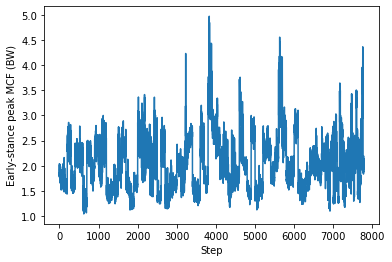

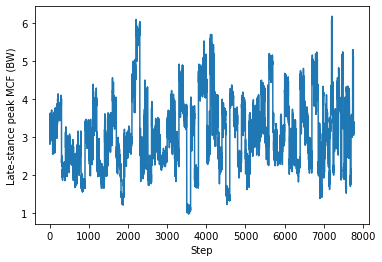

In [6]:
if outputType == 'all':
    output = np.expand_dims(MCF.T, axis = 2)
    output = scipy.signal.resample(output, 32, axis = 1)
    print("Output shape is: " + str(output.shape))
    
elif outputType == 'three':
    output = np.concatenate([peakMCF_early, minMCF], axis = 1)
    output = np.expand_dims(np.concatenate([output, peakMCF_late], axis = 1),axis = 2)
    
    # plot both peaks and valley
    plt.figure()
    plt.plot(output[:,0,0]);
    plt.ylabel("Early-stance peak MCF (BW)");
    plt.xlabel("Step");
    plt.figure()
    plt.plot(output[:,1,0]);
    plt.ylabel("Mid-stance minimum MCF (BW)");
    plt.xlabel("Step");
    plt.figure()
    plt.plot(output[:,2,0]);
    plt.ylabel("Late-stance peak MCF (BW)");
    plt.xlabel("Step");

elif outputType == 'both':
    # next step: multiple outputs (e.g. early and late-stance peaks in MCF)
    output = np.expand_dims(np.concatenate([peakMCF_early, peakMCF_late], axis = 1),axis = 2)
    print("Output shape is: " + str(output.shape))

    # plot both peaks
    plt.figure(1)
    plt.plot(output[:,0,0]);
    plt.ylabel("Early-stance peak MCF (BW)");
    plt.xlabel("Step");
    plt.figure(2)
    plt.plot(output[:,1,0]);
    plt.ylabel("Late-stance peak MCF (BW)");
    plt.xlabel("Step");

else:
    if outputType == 'early':
        # Reshape the output (nSamples, 1, 1)
        output = np.expand_dims(peakMCF_early,axis=2)
    
    elif outputType == 'late':
        output = np.expand_dims(peakMCF_early,axis=2)
        
    elif outputType == 'max':
        output = np.expand_dims(peakMCF,axis=2)

    print("Output shape is " + str(output.shape))
    # Plot output data
    plt.plot(output[:,0,0]);
    plt.ylabel("Peak MCF (BW)");
    plt.xlabel("Step");

### (6) Divide into train, development, and test sets

In [8]:
# Set the seed so it is reproducible
np.random.seed(1)
nSubjects = len(np.unique(subject)) # 68 subjects
subject_shuffle = np.unique(subject)
np.random.shuffle(subject_shuffle)

# 80-10-10 split (54-7-7 subjects)
train, dev, test = np.split(subject_shuffle, [int(0.8*len(subject_shuffle)), int(0.9*len(subject_shuffle))])
print("Train: " + str(len(train)) + " subjects")
print("Dev: " + str(len(dev)) + " subjects")
print("Test: " + str(len(test)) + " subjects")

# Find step indicies for each subject in each set (taken from Boswell et al., 2021)
trainInds = np.array(0)
for i in train:
    trainInds = np.append(trainInds,np.argwhere(subject==i)[:,0])
trainInds = trainInds[1:]
    
devInds = np.array(0)
for i in dev:
    devInds = np.append(devInds,np.argwhere(subject==i)[:,0])
devInds = devInds[1:]

testInds = np.array(0)
for i in test:
    testInds = np.append(testInds,np.argwhere(subject==i)[:,0])
testInds = testInds[1:]

# Build training, development, and test inputs and labels (taken from Boswell et al., 2021)
trainInput_full = inputMat[trainInds,:,:]
trainInput_full = trainInput_full.reshape((trainInput_full.shape[0],-1)) # flatten
trainLabels = output[trainInds,:,0]

devInput_full = inputMat[devInds,:,:]
devInput_full = devInput_full.reshape((devInput_full.shape[0],-1)) # flatten
devLabels = output[devInds,:,0]

testInput_full = inputMat[testInds,:,:]
testInput_full = testInput_full.reshape((testInput_full.shape[0],-1))
testLabels = output[testInds,:,0]

Train: 54 subjects
Dev: 7 subjects
Test: 7 subjects


### (7) Remove redundant leg inputs

In [9]:
# Extract indices of leg (every 32nd index, leave first one)
inputIdx = np.delete(np.arange(0,trainInput_full.shape[1]), np.arange(63, trainInput_full.shape[1], 32))

# Could also do some sort of input feature selection here if we wanted to!

# Remove additional leg input features
trainInput = trainInput_full[:,inputIdx]
devInput = devInput_full[:,inputIdx]
testInput = testInput_full[:,inputIdx]

print("Train input: " + str(trainInput.shape))
print("Dev input: " + str(devInput.shape))
print("Test input: " + str(testInput.shape))

Train input: (6159, 497)
Dev input: (820, 497)
Test input: (800, 497)


# Part II: Train feed-forward neural network

In the current version, we predict the early and late stance peaks of MCF, along with the mid-stance valley.

### (8) Construct model function

In [10]:
# Modified from Boswell et al., 2021

def construct_model(nHiddenUnits, nHiddenLayers, input_dim, output_dim, loss):
    np.random.seed(2)
    tf.compat.v1.set_random_seed(2)

    model = Sequential()
    kernel_regularizer= tf.keras.regularizers.L2(0.01) # added
    bias_regularizer= tf.keras.regularizers.l2(0.01) # added
    # kernel_regularizer= tf.keras.regularizers.L1L2(l1 = 1., l2 = 1.) # added
    model.add(Dense(800,input_shape = (input_dim,), kernel_initializer=glorot_normal(seed=None) , activation='relu',
             kernel_regularizer = kernel_regularizer, bias_regularizer = bias_regularizer))
    
    for i in range(nHiddenLayers-1):
        model.add(Dropout(0.01))
        model.add(Dense(nHiddenUnits, kernel_initializer=glorot_normal(seed=None) , activation='relu',
                  kernel_regularizer = kernel_regularizer, bias_regularizer = bias_regularizer))
    
    model.add(Dropout(0.01))
    model.add(Dense(output_dim,kernel_initializer=glorot_normal(seed=None),activation='linear'))
    # rmse = tf.keras.metrics.RootMeanSquaredError()
    model.compile(loss=loss,optimizer='adam', metrics=['mse'])
    return model

### (9) Train a model with customized inputs

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 800)               398400    
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                40050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2

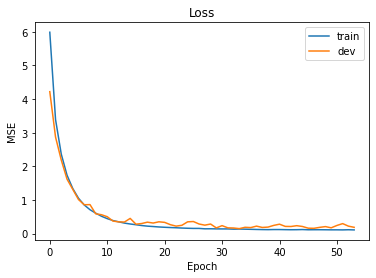

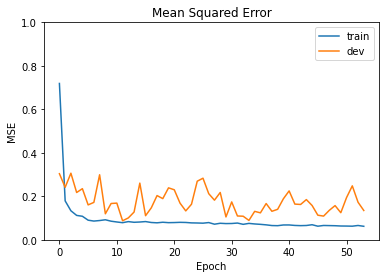

In [11]:
# Written by Delaney 5/18/21

# create model
myModel = construct_model(nHiddenUnits = 50, nHiddenLayers = 4, input_dim = trainInput.shape[1], 
                          output_dim = trainLabels.shape[1], loss = 'mse') # loss = 'mae'
myModel.summary()

# early stopping when there is no improvement in 10 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = "min", patience=10, restore_best_weights = True)

# fit model on training data
history = myModel.fit(trainInput, trainLabels, validation_data=(devInput, devLabels), epochs = 100, 
                      callbacks = [callback], verbose = 2)
# _, train_mse = myModel.evaluate(trainInput, trainLabels, verbose=0)

# plot loss and mse
plotTraining(history)

# predict on dev set
# yhat = myModel.predict(devInput)

### (10) Evaluate model

Pearsons r coefficient:
Early stance: 0.7024974312728403
Late stance: 0.9240719322531122


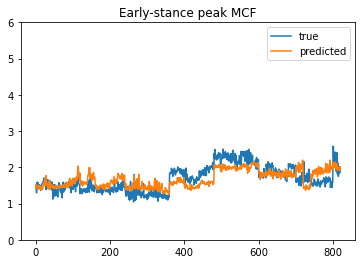

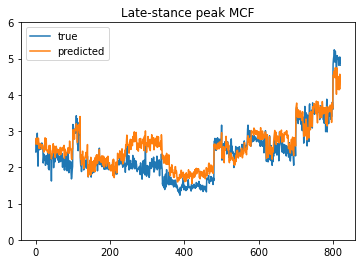

Pearsons r coefficient:
Early stance: 0.5976193573551452
Late stance: 0.8483051222405427


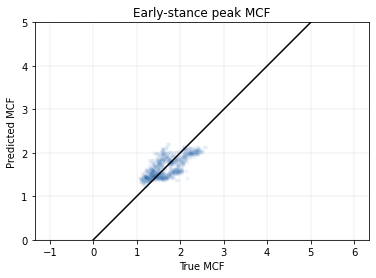

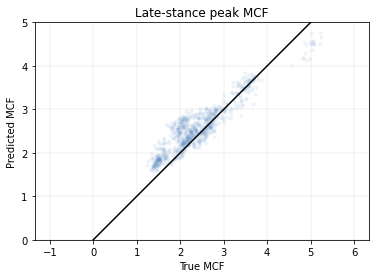

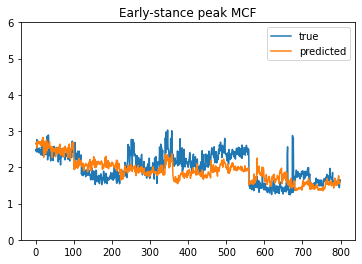

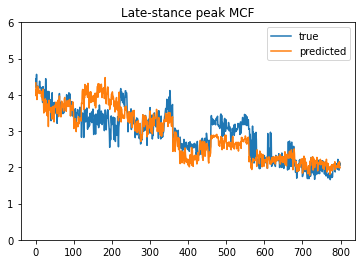

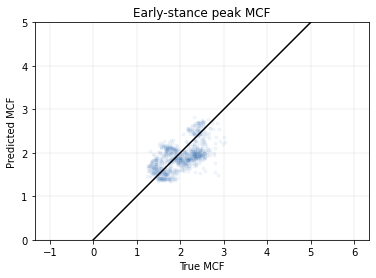

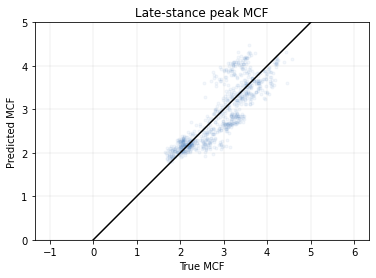

In [13]:
# predict on development and test set
yhat_dev = myModel.predict(devInput)
yhat_test = myModel.predict(testInput)

## DEV SET
pearsonr(devLabels, yhat_dev)
plotPred(devLabels, yhat_dev)

## TEST SET
pearsonr(testLabels, yhat_test) # pearson r
plotPred(testLabels, yhat_test) # plot

### (11) Save model

In [312]:
# Taken from Boswell et al., 2021

# Make directory for newly trained models
if not os.path.isdir('NewlyTrainedModels'):
    os.mkdir('NewlyTrainedModels')

# Serialize model to JSON
model_json = myModel.to_json()
with open("NewlyTrainedModels/NeuralNet_" + modeltype + "_newModel.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
myModel.save_weights("NewlyTrainedModels/NeuralNet_" + modeltype + "_newModel_weights.h5")
print("Saved model to disk")

Saved model to disk


### (12) Percentage absolute error; classifying conditions

Evaluate the significance of our results through the following tests:
- $\textbf{% Error:}$ Calculate percentage absolute error (relative to true values)
    - We compute this for each peak of MCF for each step (saved as $\texttt{perc_err_temp}$)
    - We output the mean and standard deviation across all steps
    - We compute the mean within condition for each subject (Wk 1 results only)
- $\textbf{Directional change accuracy:}$ Evaluate model's accuracy in predicting direction of MCF change from baseline
    - No threshold: evaluate model performance in capture even small changes (e.g. +0.01 BW) from baseline for each condition
    - Threshold: evaluate model's performance at capturing directional changes greater than $\texttt{thresh} = 0.05$ BW from baseline for each condition. If the model predicts a change in MCF below the threshold and the true change in MCF is also below the threshold, we consider that an accurate result.
- $\textbf{Larger peak accuracy:}$ Evaluate model's accuracy in labeling the larger peak of MCF
    - No threshold: label larger peak
    - Threshold: label larger peak or identify that the peaks are the "same" (i.e. within $\texttt{thresh}$ of each other)
- $\textbf{Gait prescribing accuracy:}$ Evaluate model's accuracy in identifying the appropriate gait modification
    - Select larger peak of baseline MCF
        - If peaks are the same, find modification that leads to maximum reduction in at least one peak
    - Find modification that leads to largest reduction in larger peak of MCF
        - If reduction is less than clinically relevant threshold, return baseline condition

### Sort data
We output $\texttt{true_temp}$ and $\texttt{pred_temp}$, which are arrays for the true peak medial contact force values and predicted medial contact force values. We average the results across all steps within a given condition for a given subject.  Both arrays are of size (noOutputs, noCond, noSub):
- noOutputs: Number of outputs predicted. In the case of 2 outputs, row 0 is the early stance peak of MCF and row 1 is the late stance peak.
- noCond: Number of conditions tested. By column, these are baseline, -5 deg, -10 deg, 5 deg, 10 deg.
- noSub: Number of subjects tested. This is in sorted order by subject number.

In [57]:
# pick dataset to analyze
y_temp = devLabels   # true labels (2, # observations)
yhat_temp = yhat_dev # predicted from model
idx_temp = devInds   # indices in data

# calculate % absolute error
perc_err_temp = np.abs(y_temp - yhat_temp) / y_temp

# extract subject labels
sub_temp = subject[idx_temp,:]
cond_temp = condition[idx_temp,:]

# initialize arrays
noOutputs = y_temp.shape[1]
noCond = 5
noSub = len(np.unique(sub_temp))
true_temp = np.zeros((noOutputs, noCond, noSub))
pred_temp = np.zeros((noOutputs, noCond, noSub))
perc_err = np.zeros((noOutputs, noCond, noSub))
sub_order_temp = np.unique(sub_temp)

# for each subject
for ii in range(noSub):
    s = sub_order_temp[ii]
    for c in range(noCond):
        idx_cond_temp = np.where((cond_temp==c) & (sub_temp==s))[0] # get idx of all trials in that condition
        # Calculate average true peak(s)
        true_temp[:,c,ii] = np.mean(y_temp[idx_cond_temp,:],axis = 0)
        # Calculate average predicted peak(s)
        pred_temp[:,c,ii] = np.mean(yhat_temp[idx_cond_temp,:], axis = 0) 
        # Calculate % absolute error
        perc_err[:,c,ii] = np.mean(perc_err_temp[idx_cond_temp,:], axis = 0)

### Percent Error
Calculate mean percentage absolute error (relative to true values)
    - We computed this for each peak of MCF for each step (saved as $\texttt{perc_err_temp}$)
    - We output the mean and standard deviation across all steps
    - We compute the mean within condition for each subject (Wk 1 results only)

In [59]:
# Mean and std of % abs err: across subjects and conditions
print("Mean percent absolute error [early late]:")
print(100*np.mean(perc_err_temp, axis = 0))
print("Standard deviation of percent absolute error:")
print(100*np.std(perc_err_temp, axis = 0))

# Mean % absolute error across subjects, separated by condition (Wk1 results only)
# print(np.mean(perc_err, axis = 2))
# print(np.std(perc_err, axis = 2))

Mean percent absolute error [early late]:
[12.71843685 13.14915768]
Standard deviation of percent absolute error:
[ 8.06575007 11.87925021]


### Directional Change Accuracy
Evaluate model's accuracy in predicting direction of MCF change from baseline (averaged across 10 steps)
- No threshold: evaluate model performance in capture even small changes (e.g. +0.01 BW) from baseline for each condition
- Threshold: evaluate model's performance at capturing directional changes greater than $\texttt{thresh} = 0.05$ BW from baseline for each condition. If the model predicts a change in MCF below the threshold and the true change in MCF is also below the threshold, we consider that an accurate result.

In [52]:
# predict direction of change from baseline
thresh = 0.1 # in BW
change = np.zeros((noOutputs, noCond-1, noSub))
change_thresh = np.zeros((noOutputs, noCond-1, noSub))
for ii in range(noSub):
    change_temp = (true_temp[:,1:,ii] < np.expand_dims(true_temp[:,0,ii],axis=1)) == (pred_temp[:,1:,ii] < np.expand_dims(pred_temp[:,0,ii],axis=1))    
    temp = (np.abs(true_temp[:,1:,ii] - np.expand_dims(true_temp[:,0,ii],axis=1)) < thresh) == (np.abs(pred_temp[:,1:,ii] - np.expand_dims(pred_temp[:,0,ii],axis=1)) < thresh)
    change[:,:,ii] = change_temp
    change_thresh[:,:,ii] = (change_temp | temp)
change_acc = np.sum(change, axis = 2)/noSub
change_acc_thresh = np.sum(change_thresh, axis = 2)/noSub

# outputs
print("No threshold accuracy: ")
print(change_acc)
print("Accuracy when thresholded at " + str(thresh) + " BW:")
print(change_acc_thresh)

print("Conditions: -5 deg, -10 deg, 5 deg, 10 deg")

No threshold accuracy: 
[[0.28571429 0.57142857 0.57142857 0.28571429]
 [0.85714286 0.85714286 0.71428571 0.71428571]]
Accuracy when thresholded at 0.1 BW:
[[0.28571429 0.71428571 0.85714286 0.57142857]
 [0.85714286 0.85714286 0.85714286 0.85714286]]
Conditions: -5 deg, -10 deg, 5 deg, 10 deg


### Larger peak accuracy
Evaluate model's accuracy in labeling the larger peak of MCF
- No threshold: label larger peak
- Threshold: label larger peak or accurately identify that the peaks are the "same" (i.e. within $\texttt{thresh}$ of each other)

In [60]:
# Label the larger peak of baseline MCF
largerPeak_true = np.argmax(true_temp[:,0,:], axis = 0)
largerPeak_pred = np.argmax(pred_temp[:,0,:], axis = 0)
largerPeak_acc = np.sum(largerPeak_true == largerPeak_pred)/noSub
print("Labeling larger peak accuracy: " + str(largerPeak_acc))

# (Threshold) label the larger peak of baseline MCF
thresh2 = 0.1  # in BW
samePeak_true = (abs(true_temp[1,0,:] - true_temp[0,0,:]) < thresh2)
samePeak_pred = (abs(pred_temp[1,0,:] - pred_temp[0,0,:]) < thresh2)
# true and model values agree that peaks are the same OR true and predicted values agree on larger peak
temp = (samePeak_true == samePeak_pred)
samePeak_acc = np.sum(temp)/noSub
print("Accuracy of labeling two peaks are the same: " + str(samePeak_acc))

Labeling larger peak accuracy: 0.8571428571428571
Accuracy of labeling two peaks are the same: 1.0


### Gait prescribing accuracy
Evaluate model's accuracy in identifying the appropriate gait modification
- Select larger peak of baseline MCF
    - If peaks are the same, find modification that leads to maximum reduction in at least one peak
- Find modification that leads to largest reduction in larger peak of MCF
    - If reduction is less than clinically relevant threshold, return baseline condition

In [62]:
# decision-making task: with what accuracy can we prescribe the correct gait modification to reduce the larger peak of MCF?
# if same ... find gait mod that leads to biggest overall reduction (but don't increase the other peak)
# else pick the bigger peak, take column-wise max, take min

thresh3 = 0.25 # clinically relevant reduction in MCF
mod_true = np.zeros((4, noSub)) # rows: larger peak, same peak, best gait condition, expected reduction (BW)
mod_pred = np.zeros((4, noSub))

# input larger peak
mod_true[0,:] = largerPeak_true
mod_pred[0,:] = largerPeak_pred
# input same peak
mod_true[1,:] = samePeak_true
mod_pred[1,:] = samePeak_pred

for ii in range(noSub):
    # TRUE
    # if two baseline peaks are the same, find mod that leads to largest overall reduction
    if (mod_true[1,ii] == 1):
        temp1 = true_temp[:,1:,ii] - np.expand_dims(true_temp[:,0,ii],axis=1)
        # if reduction is larger than clinically relevant threshold
        if (np.min(temp1) < -thresh3):
            temp2 = np.argmin(np.min(temp1, axis = 0)) # gait condition assoc. w/largest decrease
            # if this causes the other peak to increase
            if (np.max(temp1[:,temp2]) > thresh3):
                mod_true[2,ii] = 0 # keep baseline
                mod_true[3,ii] = 0.0
            else:
                mod_true[2,ii] = temp2 + 1 # best gait condition
                mod_true[3,ii] = np.min(temp1)
    else:
        temp0 = int(mod_true[0,ii]) # select larger peak
        temp1 = true_temp[temp0,1:,ii] - true_temp[temp0,0,ii]
        # if reduction is larger than clinically relevant threshold
        if (np.min(temp1) < -thresh3):
            mod_true[2,ii] = np.argmin(temp1) + 1
            mod_true[3,ii] = np.min(temp1)
        else:
            mod_true[2,ii] = 0 # keep baseline
            mod_true[3,ii] = 0.0
    
    # PREDICTED
    # if two baseline peaks are the same, find mod that leads to largest overall reduction
    if (mod_pred[1,ii] == 1):
        temp1 = pred_temp[:,1:,ii] - np.expand_dims(pred_temp[:,0,ii],axis=1)
        # if reduction is larger than clinically relevant threshold
        if (np.min(temp1) < -thresh3):
            temp2 = np.argmin(np.min(temp1, axis = 0)) # gait condition assoc. w/largest decrease
            # if this causes the other peak to increase by some clinically relevant amount
            if (np.max(temp1[:,temp2]) > thresh3):
                mod_pred[2,ii] = 0 # keep baseline
                mod_pred[3,ii] = 0.0
            else:
                mod_pred[2,ii] = temp2 + 1 # best gait condition
                mod_pred[3,ii] = np.min(temp1)
    else:
        temp0 = int(mod_pred[0,ii]) # select larger peak
        temp1 = pred_temp[temp0,1:,ii] - pred_temp[temp0,0,ii]
        # if reduction is larger than clinically relevant threshold
        if (np.min(temp1) < -thresh3):
            mod_pred[2,ii] = np.argmin(temp1) + 1
            mod_pred[3,ii] = np.min(temp1)
        else:
            mod_pred[2,ii] = 0 # keep baseline
            mod_pred[3,ii] = 0.0

mod_acc = np.sum(mod_true[2] == mod_pred[2])/noSub
dir_acc = 0
dir_base_acc = 0
for jj in range(noSub):
    if (mod_true[2,jj] == 0):
        if (mod_pred[2,jj] == 0):
            dir_acc += 1
            dir_base_acc += 1
    elif (mod_true[2,jj] == 1) or (mod_true[2,jj] == 2):
        if (mod_pred[2,jj] == 1) or (mod_pred[2,jj] == 2):
            dir_acc += 1
            dir_base_acc += 1
        if (mod_pred[2,jj] == 0):
            dir_base_acc += 1
    elif (mod_true[2,jj] == 3) or (mod_true[2,jj] == 4):
        if (mod_pred[2,jj] == 3) or (mod_pred[2,jj] == 4):
            dir_acc += 1
            dir_base_acc += 1
        if (mod_pred[2,jj] == 0):
            dir_base_acc += 1
dir_acc = dir_acc/noSub
dir_base_acc = dir_base_acc/noSub
            
print("True modification: " + str(mod_true[2]))
print("Pred modification: " + str(mod_pred[2]))
print("Accuracy: " + str(np.round(mod_acc,4)))
print("Directional Accuracy (prescribes right direction): " + str(np.round(dir_acc,4)))
print("Accuracy of not prescribing the wrong direction (or a modification when one is not needed): " + str(np.round(dir_base_acc,4)))
print(np.round(mod_true[3],2))
print(np.round(mod_pred[3],2))

True modification: [0. 0. 4. 0. 0. 1. 2.]
Pred modification: [2. 0. 4. 1. 0. 0. 2.]
Accuracy: 0.5714
Directional Accuracy (prescribes right direction): 0.5714
Accuracy of not prescribing the wrong direction (or a modification when one is not needed): 0.7143
[ 0.    0.   -0.31  0.    0.   -0.55 -0.37]
[-0.42  0.   -0.39 -0.3   0.    0.   -0.42]


### Testing space

In [36]:
print(mod_pred[2,1])
np.median(np.abs(y_temp - yhat_temp),axis = 0)

4.0


array([0.26712762, 0.2205626 ])

### (13) Multiple Linear Regression

Evaluate performance of a simple multiple linear regression model in comparison to neural network. We modeled this as a single layer neural network with linear activation. The input dimension is the number of input features, output dimension is 2 for predicting both peaks.

In [27]:
# Linear regression
def construct_regression_model(input_dim, output_dim, loss):
    np.random.seed(2)
    tf.compat.v1.set_random_seed(2)

    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim,kernel_initializer=glorot_normal(seed=None),activation='linear'))
    model.compile(loss=loss,optimizer='adam', metrics=['mse'])
    return model

#### Train model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2)                 996       
Total params: 996
Trainable params: 996
Non-trainable params: 0
_________________________________________________________________


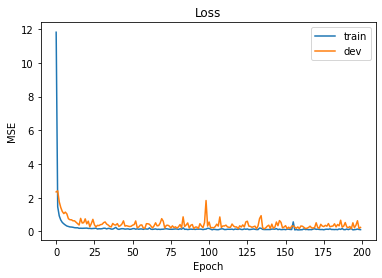

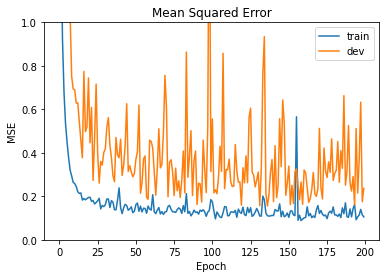

In [28]:
regModel = construct_regression_model(input_dim = trainInput.shape[1], output_dim = trainLabels.shape[1], loss = 'mse')
regModel.summary()

# early stopping when there is no improvement in "patience" epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = "min", patience=100, restore_best_weights = True)

# fit model on training data
regHistory = regModel.fit(trainInput, trainLabels, validation_data=(devInput, devLabels), epochs = 200, 
                      callbacks = [callback], verbose = 0)
# _, train_mse = myModel.evaluate(trainInput, trainLabels, verbose=0)

# plot loss during training
plotTraining(regHistory)

#### Evaluate model performance on dev and test sets

Mean percent absolute error [early late]:
[24.70798789 18.87429774]
Standard deviation of percent absolute error:
[19.0788348  15.64487141]
Pearsons r coefficient:
Early stance: 0.46159772033987084
Late stance: 0.7811104799010028


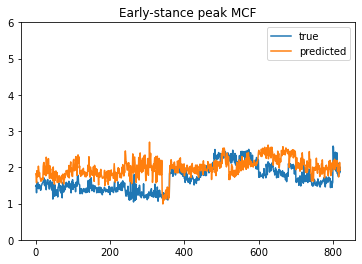

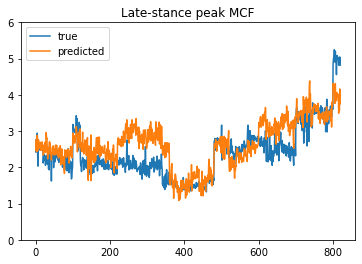

Pearsons r coefficient:
Early stance: 0.5458185100584709
Late stance: 0.7293722914017201


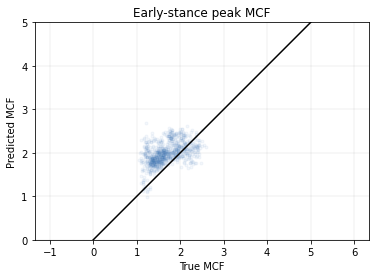

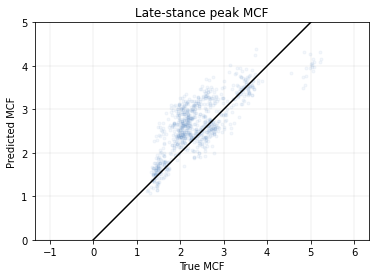

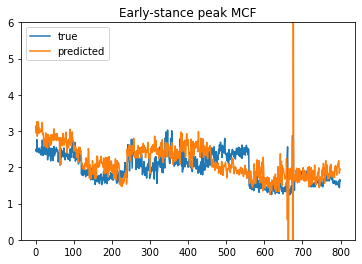

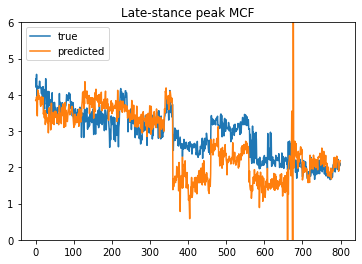

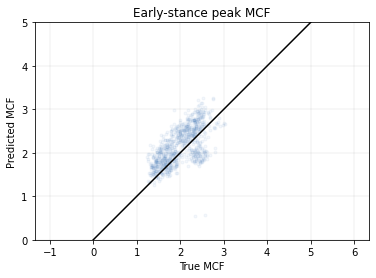

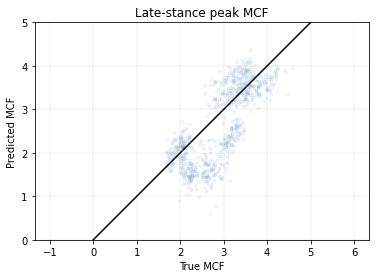

In [63]:
# predict on development and test set
yhat_devreg = regModel.predict(devInput)
yhat_testreg = regModel.predict(testInput)

# Calculate % mean absolute error
perc_err_reg = np.abs(yhat_devreg - devLabels) / devLabels
# Mean and std of % abs err: across subjects and conditions
print("Mean percent absolute error [early late]:")
print(100*np.mean(perc_err_reg, axis = 0))
print("Standard deviation of percent absolute error:")
print(100*np.std(perc_err_reg, axis = 0))

## DEV SET
pearsonr(devLabels, yhat_devreg)
plotPred(devLabels, yhat_devreg)

## TEST SET
pearsonr(testLabels, yhat_testreg) # pearson r
plotPred(testLabels, yhat_testreg) # plot